# Exercise 8: Principal component analysis 

*This notebook has been created by Julia Kukulies (julia.kukulies@gu.se) and is as a modified version from the exercise for GVN370 created by Céline Heuzé.*


Yesterday told us which frequencies dominate a timeseries. But in general, you do not have just one
timeseries. You have global timeseries! i.e. one timeseries per grid cell, times thousands of grid cells.
Do you want to produce and look at thousands of Fourier spectra? Personally I don’t.
Instead, we are going to use a fantastic method that is some sort of 3D Fourier transform AND that is
capable of filtering your signal...


As usual, I let you gather more information online using your favourite search engine. The method we
will use has different names depending on who you are talking to: Principal Component Analysis (PCA),
Principle Component Decomposition, Single Value Decomposition (SVD), or Empirical Orthogonal
Functions (EOF) are the most common. In a mathematical sense, PCA and EOF (what we do today) are
a subtype of SVDs, but there are many more. In climate science, you will hear about Principal
Component to refer to the temporal part of this decomposition, and about EOFs for the spatial part.
In today’s example, both are calculated simultaneously.

**So, today the only thing we do is to perform a PCA/EOF decomposition onto our signal.**


I will again use the 31-year monthly global SST, but you can use something else if you prefer.

So, one last time, import you packages and load your data as an xarray. There are a few python packages that can do this type of analysis and you are free to choose any. Below I show two examples. 



1. A quite high-level python package that provides a very specfic solver for spatial EOFs with gridded climate data and supports xarray: [**eofs**](https://ajdawson.github.io/eofs/latest/api/eofs.xarray.html#module-eofs.xarray) -> very convenient to use, but not as universal as the one below. You need to understand a bit less of what you are actually doing which may be comfortable, but not always advantageous. So I will also introduce you to a package which is  slightly more abstract but can be used for many similar problems: 


2. A very common and widely used machine learning library with various tools for predictive data analysis [**sklearn.decomposition.PCA**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Let us start from 3 numpy arrays/xarrays with the following dimensions:**
- sst is longitude x latitude x time (one value per month x 31 years)
- lon and lat are 2D; I have already applied meshgrid to them as I know I will need to plot maps.


**What we will get when using the EOF/PCA functions:** 
- the 1D timeseries for each PC, ordered after their explained variances (dimensions: timesteps x number of PCs)
- a 2D (lon x lat) grid for each PC where each location has a value that indicate the strengths of the respective (these are often referred t as EOFs) 
- a 1D array containing the explained variances for each PC (e.g. how much of the variance in the dataset can be attributed to the pattern seen in the timeseries for the first PC ? whereas the map shows you how important the same pattern is at a given location)


## Dealing with missing values 


Except that if you have NaNs in your data, that is not going to work. It is a really common issue in
coding for climate science, that codes are not made for real patchy data. Often, the packages are
eventually improved to accept NaNs and just ignore them. 


So what do you do? You have three alternatives:


- you work only with the data that are non-NaN
- you set the NaN-values to something else
- you interpolate so that you do not have any NaN left


Discuss the advantages and inconvenients of each method now. Once you decided what to do and got the code working (in the case of the sst, just remove the last
three time steps), you will obtain:


## Using eofs:

In this particular package missing values are only allowed when consistent overtime (like ocean fields over land in this case). So we do not need to care about the land values here and just remove the last three values of the time dimension, which contained missing values!  The output variables **eofs** and **pcs** contain the spatial maps and corresponding timeseries of each principal component. THese are returned as xarrays. 

So the 3 steps which are involved are basically:  


In [114]:
# 1. create a solver class that is specific for xarray (numpy and iris also supported)
# note that we can even perform 

solver = eofs.xarray.Eof(sst)

# 2. retrieve the first six EOFs (spatial grid) from the solver class
eofs_sst = solver.eofs(neofs=6)

# 3. retrieve the first six PCs (timeseries) from the solver class
pcs = solver.pcs(npcs=6)

# 4. and wow we also want to now the values for how much variance each PC can explain
explained_variances = solver.varianceFraction(neigs=6)

print('Explained variance: ', explained_variances.values )

Explained variance:  [0.8310712  0.03599845 0.03121099 0.01095935 0.008018   0.00585881]


If you have never used this option before, now is a good time to learn about [**plt.subplots()**](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots) and [**plt.subplot()**](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html). I know, confusing that there are two packages which basically do the same but with slightly different syntax and almost the same name. When you use one of these methods, it is also very handy to combine in a loop, for example to plot each PC:

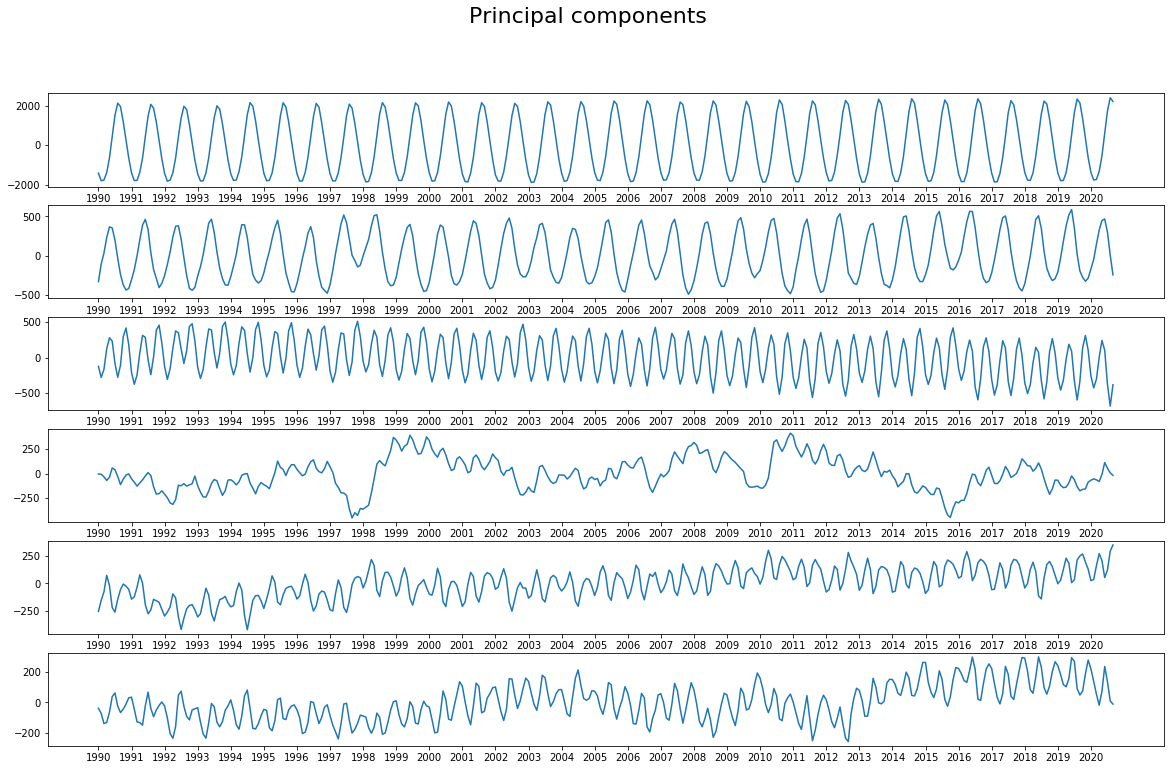

In [61]:
fig, axes = plt.subplots(6, figsize= (20,12))

fig.suptitle('Principal components', fontsize= 22)
for i in np.arange(np.shape(pcs)[1]):
    axes[i].plot(pcs[:,i].values)
    axes[i].set_xticks(np.arange(np.shape(pcs)[0])[::12])
    axes[i].set_xticklabels(pcs.time.dt.year.values[::12])
    
plt.show()

As you can see, the y-axis is rather exotic. That’s why it is quite common to normalise the data before performing this type of analysis (shown in sklearn example). 


Anyway, what we see again is that the seasonal cycle dominates with 90% of the variance. I suspect
PC2 is the El Niño variability, but we’ll have to check the EOF to be sure. PC3 looks a lot like the climate
change / global warming signal. And the last three that explain 1% or less of the variance, I don’t know.

Let’s do a figure with subplots again, this time where each subplot is one of the EOFs maps, so you need to use cartopy again if you want to make a nice map. This time I use [plt.subplot()](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html), because it is handy to use together with cartopy as you can give the projection as an input argument. 

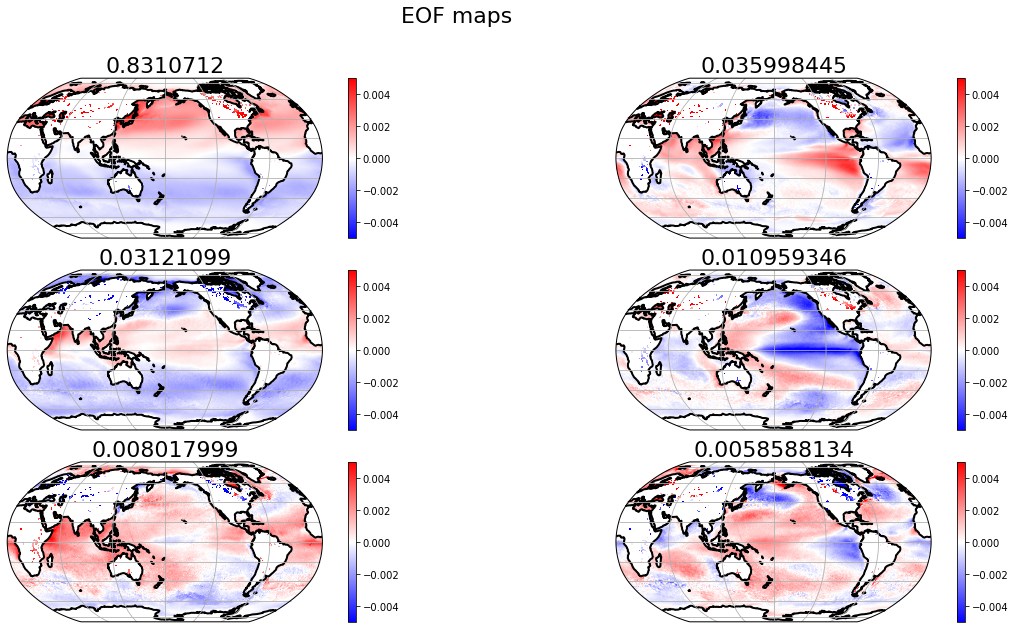

In [116]:
fig = plt.figure(figsize=(20,10))

fig.suptitle('EOF maps', fontsize= 22)

for i in np.arange(np.shape(eofs_sst)[0]):
    # note that the indexing of the plot position works different with plt.suplot()
    ax = plt.subplot(321+ i, projection=ccrs.Robinson(central_longitude = 180))
    m = ax.pcolormesh(lons,lats, eofs_sst[i].values, transform= ccrs.PlateCarree(), cmap = 'bwr', vmin = -0.005, vmax = 0.005)
    # set title with explained variance for respective EOF 
    ax.set_title(explained_variances.values[i], fontsize= 22)
    # add coastlines 
    ax.coastlines(color = 'black', linewidth = 2.0)
    ax.gridlines()
    # colorbar formatting
    cbar= plt.colorbar(m)



**What can you see in those maps?**

##  Using scikit learn:

Again we have 4 steps, but these look slightly differently (you have to reshape the data first because the PCA is usually performed on a 2D matrix that has is defined by how many features (here: each monthly timestep) and how many samples (here: each grid point) you have). The practical thing here is that you get the timeseries (PCs) and 2D grids (EOFS) as well as the explained variances all as attributes of your PCA object. Note that you need to


In [33]:
# 1. reshape 3D input array to 2D input matrix with  n_features x n_gridpoints (features are time dimension here)
n_features = np.shape(sst)[0]
n_gridpoints = np.shape(sst)[1]*np.shape(sst)[2]
data= np.reshape(sst.values, (n_features,n_gridpoints))
data = data.transpose()

# 2. normalization of input data 
data_norm = normalize(data)

# 3. perform PCA (EOF) on data 
pca = PCA(n_components = 4)
# to create the 2D grid we need to fit the pca object
grid = pca.fit_transform(data_norm) 
# comps are the timeseries 
comps= pca.components_

# 4. reshape data space back to grid (pca1 etc are the 2D EOF maps)
pca1= np.reshape(grid[:,0], ((np.shape(sst)[1],np.shape(sst)[2])))
pca2= np.reshape(grid[:,1], ((np.shape(sst)[1],np.shape(sst)[2])))
pca3= np.reshape(grid[:,2], ((np.shape(sst)[1],np.shape(sst)[2])))
pca4= np.reshape(grid[:,3], ((np.shape(sst)[1],np.shape(sst)[2])))

## Remove the seasonal cycle

Anyway, what we see again is that the seasonal cycle dominates with 90% of the variance. I suspect
PC2 is the El Niño variability, but we’ll have to check the EOF to be sure. PC3 looks a lot like the climate
change / global warming signal. And the last three that explain 1% or less of the variance, I don’t know.



And if now you remove the seasonal cycle from sst (you choose your method) and perform an EOF
again, what do you obtain? My PCs become this:

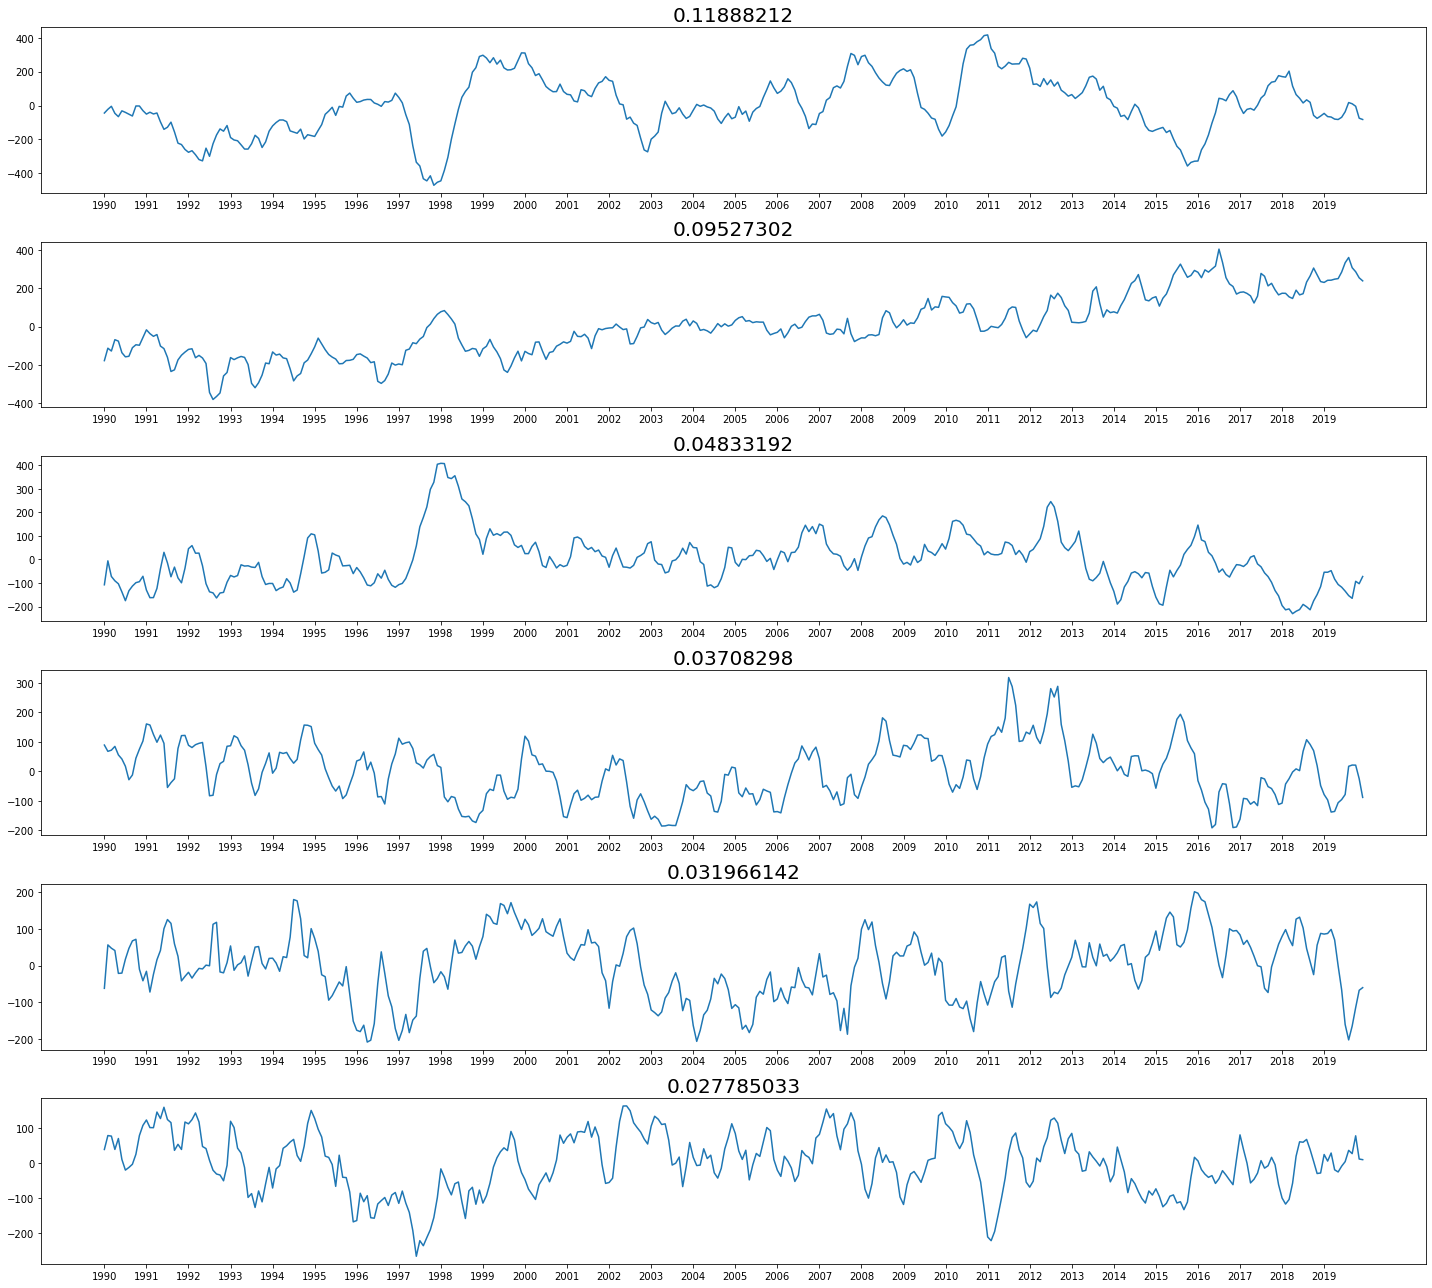

In [32]:
fig, axes = plt.subplots(6, figsize= (20,18))

for i in np.arange(np.shape(pcs)[1]):
    axes[i].plot(pcs[:,i].values)
    axes[i].set_title(str(explained_variances.values[i]), fontsize = 20)
    axes[i].set_xticks(np.arange(np.shape(pcs)[0])[::12])
    axes[i].set_xticklabels(pcs.time.dt.year.values[::12])
    
plt.tight_layout()
plt.show()

Suddenly, you need several PCs to reach a satisfying level of variance explained (typically, 50%).

I’ll stop here, but I encourage you to produce more PC/EOF. In particular, try to recreate the NAO
index, which is defined as “the first EOF of the sea level pressure (or SSH sometimes) over the North
Atlantic”.